# Imports

In [8]:
import os
import glob
import tqdm

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as F

# Loading dataset and testing

In [9]:
train_anno = pd.read_csv("train-rle.csv")

In [10]:
train_anno_unique = train_anno.drop_duplicates(["ImageId"])
print(len(train_anno))
print(len(train_anno_unique))
print(len([annotation for annotation in train_anno_unique["EncodedPixels"].to_list() if annotation != " -1"]))

11582
10675
2379


# Various Utility Functions

In [11]:
def run_length_decode(rle: str, height: int = 1024, width: int = 1024, fill_value: int = 1) -> np.ndarray:
    """
    Decodes a Run-Length Encoded (RLE) mask into a 2D binary mask.
    """
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

In [12]:
def np_mask_to_bb(mask: np.ndarray):
    rows, cols = np.where(mask)
    if rows.size > 0 and cols.size > 0:
        ymin = np.min(rows)
        ymax = np.max(rows)
        xmin = np.min(cols)
        xmax = np.max(cols)

        return xmin, ymin, xmax, ymax
    else:
        print("No foreground pixels found in the mask.")
        return -1, -1, -1, -1

In [13]:
test_img = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)
test_mask_img = cv2.imread("test_mask.png", cv2.IMREAD_GRAYSCALE)
print(test_img.shape)
print(test_mask_img.shape)
combined = test_img + test_mask_img*1000

fig, axes = plt.subplots(nrows=1, ncols=3, dpi=200) # Creates 1 row, 2 columns of subplots

axes[0].imshow(test_img)
axes[1].imshow(test_mask_img)
axes[2].imshow(combined)
plt.show()

[ WARN:0@10.388] global loadsave.cpp:268 findDecoder imread_('test.png'): can't open/read file: check file path/integrity
[ WARN:0@10.388] global loadsave.cpp:268 findDecoder imread_('test_mask.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

# Testing OBB from mask

/var/folders/d0/k5pp1mc555bcl1qs6mvttwt40000gn/T/ipykernel_88269/3882224326.py:8: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  image_with_obb = cv2.drawContours(test_img.copy(), [np.int0(box_points)], 0, (0,255,0), 2)


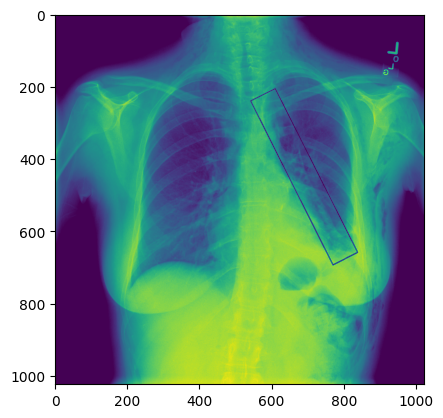

In [ ]:
if test_mask_img.dtype != np.uint8:
        test_mask_img = test_mask_img.astype(np.uint8)

contours, _ = cv2.findContours(test_mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
rotated_rect = cv2.minAreaRect(largest_contour)
box_points = cv2.boxPoints(rotated_rect)  # Returns 4 corner points
image_with_obb = cv2.drawContours(test_img.copy(), [np.int0(box_points)], 0, (0,255,0), 2)

plt.imshow(image_with_obb)

# Test with OBBs and other images, with function

In [ ]:
import cv2
import numpy as np

def get_oriented_bboxes(mask):
    """
    Extract oriented bounding boxes for all objects in a segmentation mask.
    
    Args:
        mask: 2D numpy array (binary or labeled segmentation mask)
        
    Returns:
        List of dictionaries, each containing:
        - 'points': 4 corner coordinates of OBB [(x1,y1), ..., (x4,y4)] normalized to [0,1]
        - 'center': (x, y) of box center normalized to [0,1]
        - 'size': (width, height) of box normalized to [0,1]
        - 'angle': rotation angle in degrees
    """
    # Convert to binary mask if not already
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = (mask > 0).astype(np.uint8) * 255
    
    # Find all contours (objects)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get image dimensions for normalization
    img_height, img_width = mask.shape[:2]
    
    obbs = []
    for contour in contours:
        # Get rotated rectangle (requires at least 5 points)
        if len(contour) >= 5:
            rot_rect = cv2.minAreaRect(contour)
            box_points = cv2.boxPoints(rot_rect)
            (cx, cy), (w, h), angle = rot_rect
            
            # Normalize coordinates and dimensions
            normalized_points = box_points / np.array([img_width, img_height])
            normalized_center = (cx / img_width, cy / img_height)
            normalized_size = (w / img_width, h / img_height)
            
            best_box = {
                'points': normalized_points,  # 4 corner points normalized
                'center': normalized_center,
                'size': normalized_size,
                'angle': angle  # angle doesn't need normalization
            }
            obbs.append(best_box)
    return obbs

def visualize_obbs(image, obbs, color=(0, 255, 0), thickness=2):
    """Draw oriented bounding boxes on an image
    
    Args:
        image: Original image (numpy array)
        obbs: List of OBB dictionaries with normalized coordinates [0,1]
        color: BGR tuple for box color
        thickness: Line thickness
        
    Returns:
        Visualization image with drawn OBBs
    """
    vis = image.copy()
    height, width = image.shape[:2]
    
    for obb in obbs:
        # Scale points back to image coordinates
        scaled_points = (obb['points'] * np.array([width, height])).astype(int)
        scaled_center = (int(obb['center'][0] * width), 
                         int(obb['center'][1] * height))
        
        # Draw the oriented bounding box
        cv2.drawContours(vis, [scaled_points], 0, color, thickness)
        
        # Mark center point (red by default)
        cv2.circle(vis, scaled_center, 3, (0, 0, 255), -1)
        
    return vis

In [ ]:
#1.2.276.0.7230010.3.1.4.8323329.307.1517875162.311533

bulky_mask = cv2.imread("bulky_mask.png", cv2.IMREAD_GRAYSCALE)
bulky_original = cv2.imread("bulky_original.png", cv2.IMREAD_GRAYSCALE)

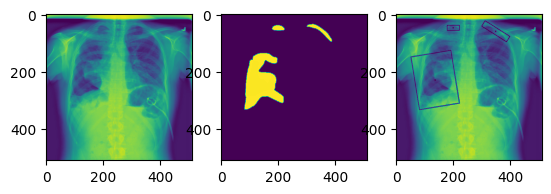

In [ ]:
bbs = get_oriented_bboxes(bulky_mask)
visualistion = visualize_obbs(bulky_original, bbs)

fig, axes = plt.subplots(1, 3)

axes[0].imshow(bulky_original)
axes[1].imshow(bulky_mask)
axes[2].imshow(visualistion)

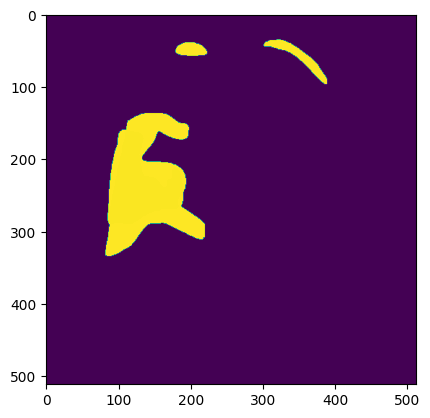

In [ ]:
plt.imshow(bulky_mask)

In [ ]:
bulky_annotations_original = train_anno[train_anno["ImageId"] == "1.2.276.0.7230010.3.1.4.8323329.307.1517875162.311533"]

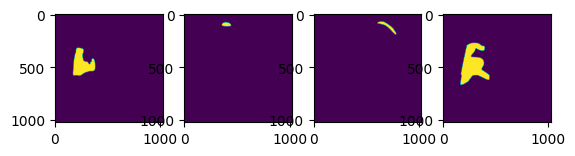

In [ ]:
bulky_rle = bulky_annotations_original["EncodedPixels"].to_list()

fig, axes = plt.subplots(nrows=1, ncols=4) # Creates a figure with 1 row and 2 columns of subplots

for index, anno in enumerate(bulky_rle):
    mask = run_length_decode(anno)
    axes[index].imshow(mask)

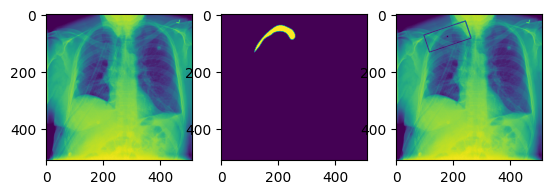

In [ ]:
curvy_mask = cv2.imread("curvy_mask.png", cv2.IMREAD_GRAYSCALE)
curvy_original = cv2.imread("curvy_original.png", cv2.IMREAD_GRAYSCALE)

bbs = get_oriented_bboxes(curvy_mask)
visualistion = visualize_obbs(curvy_original, bbs)

fig, axes = plt.subplots(1, 3)

axes[0].imshow(curvy_original)
axes[1].imshow(curvy_mask)
axes[2].imshow(visualistion)

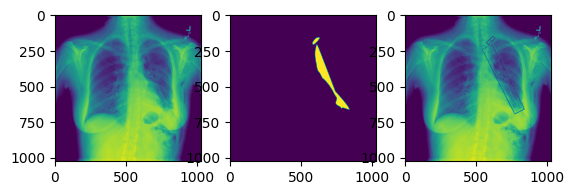

In [ ]:
bbs = get_oriented_bboxes(test_mask_img)
visualistion = visualize_obbs(test_img, bbs)

fig, axes = plt.subplots(1, 3)

axes[0].imshow(test_img)
axes[1].imshow(test_mask_img)
axes[2].imshow(visualistion)

# Function to process all images

In [ ]:
def process_dir_of_masks(dir: str) -> pd.DataFrame:
    output_list = []
    glob_path = os.path.join(dir, "*.png")
    files = glob.glob(glob_path)
    for file in tqdm.tqdm(files):
        cur_filename = os.path.splitext(os.path.basename(file))[0]
        cur_mask = cv2.imread(file)
        boxes = get_oriented_bboxes(cur_mask)
        if boxes:
            for box in boxes:
                output_list.append([cur_filename, box])
        else:
            output_list.append([cur_filename, None])

    return_df = pd.DataFrame(output_list, columns=['image_id', "box"])
    return return_df

df = process_dir_of_masks("/Users/kaichenchai/Documents/Projects/siim-acr_512/mask/")
df.to_json("full_mask_output.json", orient='records', indent=2, index=None)

100%|██████████| 10712/10712 [00:13<00:00, 819.88it/s]


# Creating regular bounding boxes

In [14]:
def get_yolo_bboxes(mask):
    """
    Extract YOLO-style bounding boxes (cx, cy, w, h) for all objects in a segmentation mask.
    
    Args:
        mask: 2D numpy array (binary or labeled segmentation mask)
        
    Returns:
        List of tuples: (cx, cy, w, h) normalized to [0,1]
    """
    # Convert to binary mask if not already
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = (mask > 0).astype(np.uint8) * 255
    
    # Find all contours (objects)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get image dimensions for normalization
    img_height, img_width = mask.shape[:2]
    
    yolo_bboxes = []
    for contour in contours:
        if len(contour) >= 2:  # need at least 2 points for bbox
            x, y, w, h = cv2.boundingRect(contour)
            
            # Convert to YOLO format
            cx = (x + w / 2.0) / img_width
            cy = (y + h / 2.0) / img_height
            nw = w / img_width
            nh = h / img_height
            
            yolo_bboxes.append((cx, cy, nw, nh))
    
    return yolo_bboxes


In [15]:
def process_dir_of_masks_to_yolo_format(dir: str) -> pd.DataFrame:
    output_list = []
    glob_path = os.path.join(dir, "*.png")
    files = glob.glob(glob_path)
    for file in tqdm.tqdm(files):
        cur_filename = os.path.splitext(os.path.basename(file))[0]
        cur_mask = cv2.imread(file)
        boxes = get_yolo_bboxes(cur_mask)
        if boxes:
            for box in boxes:
                output_list.append([cur_filename, box])
        else:
            output_list.append([cur_filename, None])

    return_df = pd.DataFrame(output_list, columns=['image_id', "box"])
    return return_df

In [17]:
df = process_dir_of_masks_to_yolo_format("/Users/kaichenchai/Documents/Projects/siim-acr_512/mask/")
df.to_json("bb_full_mask_output.json", orient='records', indent=2, index=None)

100%|██████████| 10712/10712 [00:08<00:00, 1214.01it/s]
